# LSTM

## Problem 1 - Univariate Forecasting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.Pipeline import Transformer, Reverter, Pipeline
from scalecast.util import (
    find_optimal_transformation, 
    gen_rnn_grid,
    backtest_for_resid_matrix,
    get_backtest_resid_matrix,
    overwrite_forecast_intervals,
    infer_apply_Xvar_selection,
)
from scalecast import GridGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pandas_datareader as pdr

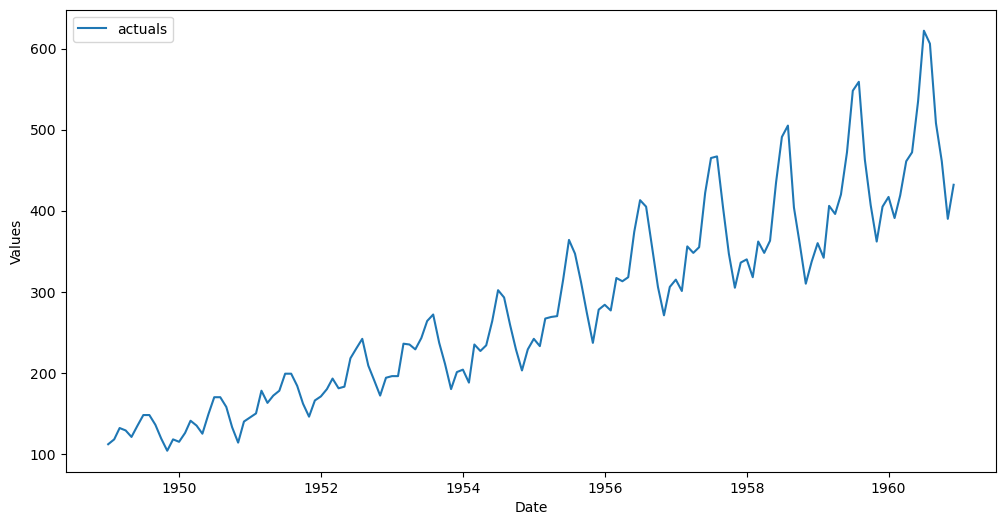

In [2]:
data = pd.read_csv('AirPassengers.csv',parse_dates=['Month'])

f = Forecaster(
    y=data['#Passengers'],
    current_dates=data['Month'],
    future_dates = 24,
)

f.plot()
plt.show()

In [3]:
def forecaster(f):
    f.set_estimator('rnn')
    f.manual_forecast(
        lags = 18,
        layers_struct = [
            ('LSTM',{'units':36,'activation':'tanh'}),
        ],
        epochs=200,
        call_me = 'lstm',
    )

transformer = Transformer(
    transformers = [
        ('DetrendTransform',{'poly_order':2}),
        'DeseasonTransform',
    ],
)

reverter = Reverter(
    reverters = [
        'DeseasonRevert',
        'DetrendRevert',
    ],
    base_transformer = transformer,
)

pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f = pipeline.fit_predict(f)

Epoch 1/200
4/4 [==============================] - 1s 6ms/step - loss: 0.3688
Epoch 2/200
4/4 [==============================] - 0s 6ms/step - loss: 0.3499
Epoch 3/200
4/4 [==============================] - 0s 6ms/step - loss: 0.3314
Epoch 4/200
4/4 [==============================] - 0s 5ms/step - loss: 0.3114
Epoch 5/200
4/4 [==============================] - 0s 6ms/step - loss: 0.2872
Epoch 6/200
4/4 [==============================] - 0s 5ms/step - loss: 0.2577
Epoch 7/200
4/4 [==============================] - 0s 6ms/step - loss: 0.2261
Epoch 8/200
4/4 [==============================] - 0s 6ms/step - loss: 0.2044
Epoch 9/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1807
Epoch 10/200
4/4 [==============================] - 0s 5ms/step - loss: 0.1608
Epoch 11/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1520
Epoch 12/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1460
Epoch 13/200
4/4 [==============================] - 0s 6ms/st

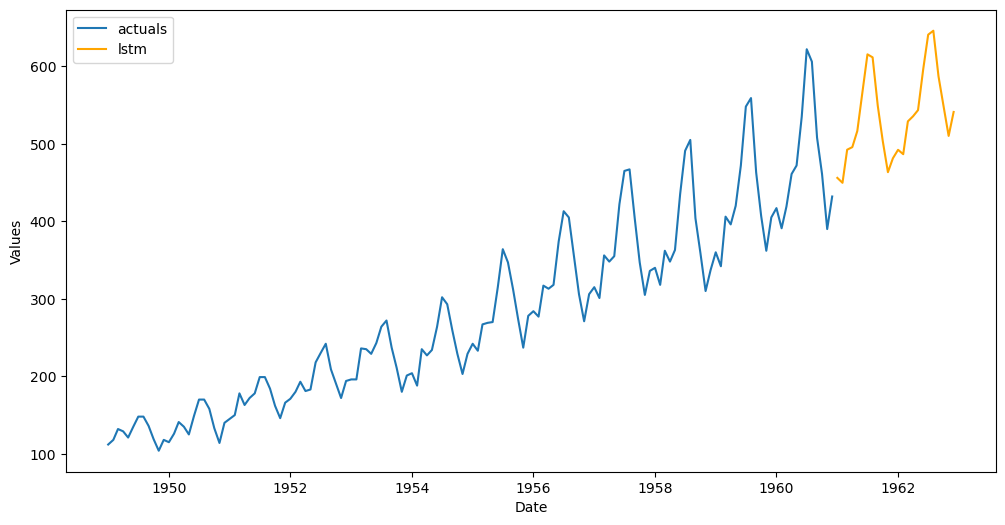

In [4]:
f.plot()
plt.savefig('LSTM Univariate.png')
plt.show()

## Problem 2 - Multivariate Forecasting

In [5]:
data = pd.read_csv('avocado.csv')

In [6]:
# demand
vol = data.groupby('Date')['Total Volume'].sum()
# price
price = data.groupby('Date')['AveragePrice'].sum()

fvol = Forecaster(
    y = vol,
    current_dates = vol.index,
    test_length = 13,
    validation_length = 13,
    future_dates = 13,
    metrics = ['rmse','r2'],
)
fprice = Forecaster(
    y = price,
    current_dates = price.index,
    future_dates = 13,
)

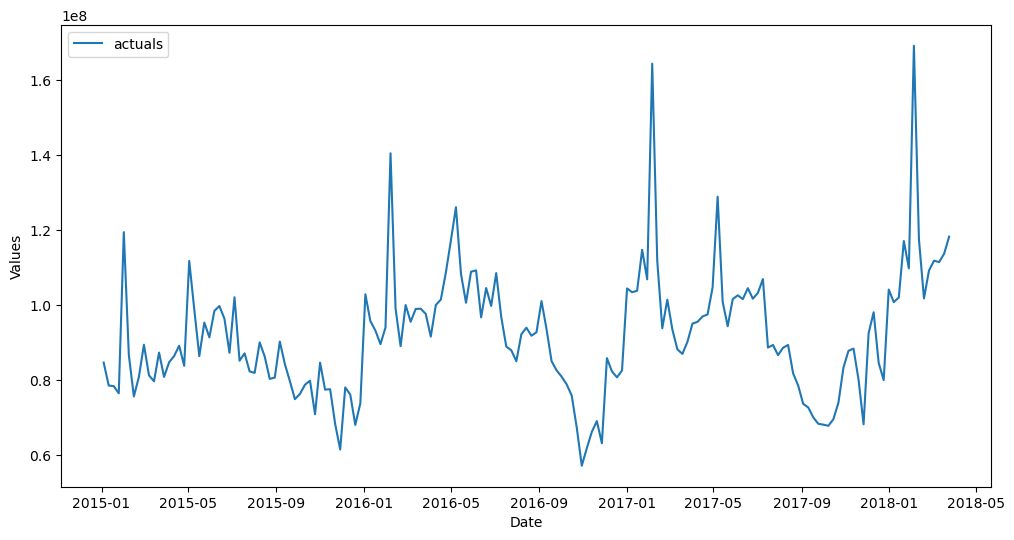

In [7]:
fvol.plot()
plt.show()

In [8]:
transformer, reverter = find_optimal_transformation(
    fvol,
    set_aside_test_set=True, # prevents leakage so we can benchmark the resulting models fairly
    return_train_only = True, # prevents leakage so we can benchmark the resulting models fairly
    verbose=True,
    detrend_kwargs=[
        {'loess':True},
        {'poly_order':1},
        {'ln_trend':True},
    ],
    m = 52, # what makes one seasonal cycle?
    test_length = 4,
)

Using mlr model to find the best transformation set on 1 test sets, each 4 in length.
All transformation tries will be evaluated with 52 lags.
Last transformer tried:
[]
Score (rmse): 10788435.478499832
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (rmse): 17367936.06969349
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (rmse): 12269036.46992314
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'ln_trend': True})]
Score (rmse): 12093617.597284064
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 52, 'model': 'add'})]
Score (rmse): 9289548.042079216
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 52, 'model': 'add'}), ('Transform', BoxcoxTransform, {'lmbda': -0.5})]
Score (rmse): 104

In [9]:
fprice = transformer.fit_transform(fprice)
fvol = transformer.fit_transform(fvol)

In [10]:
rnn_grid = gen_rnn_grid(
    layer_tries = 10,
    min_layer_size = 3,
    max_layer_size = 5,
    units_pool = [100],
    epochs = [100],
    dropout_pool = [0,0.05],
    validation_split=.2,
    callbacks=EarlyStopping(
      monitor='val_loss',
      patience=3,
    ),
    random_seed = 20,
) # creates a grid of hyperparameter values to tune the LSTM model

In [11]:
def forecaster(fvol,fprice):
    # naive forecast for benchmarking
    fvol.set_estimator('naive')
    fvol.manual_forecast()
    # univariate lstm model
    fvol.add_ar_terms(13) # the model will use 13 series lags
    fvol.set_estimator('rnn')
    fvol.ingest_grid(rnn_grid)
    fvol.tune()
    fvol.auto_forecast(call_me='lstm_univariate')
    # multivariate lstm model
    fvol.add_series(fprice.y,called='price')
    fvol.add_lagged_terms('price',lags=13,drop=True)
    fvol.ingest_grid(rnn_grid)
    fvol.tune()
    fvol.auto_forecast(call_me='lstm_multivariate')

In [12]:
forecaster(fvol=fvol,fprice=fprice)

1/1 [==============================] - 0s 288ms/step
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-09-20 09:13:34         2234
metadata.json                                  2023-09-20 09:13:34           64
variables.h5                                   2023-09-20 09:13:34       524080
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-09-20 09:13:34         2234
me

In [13]:
fvol = reverter.fit_transform(fvol)

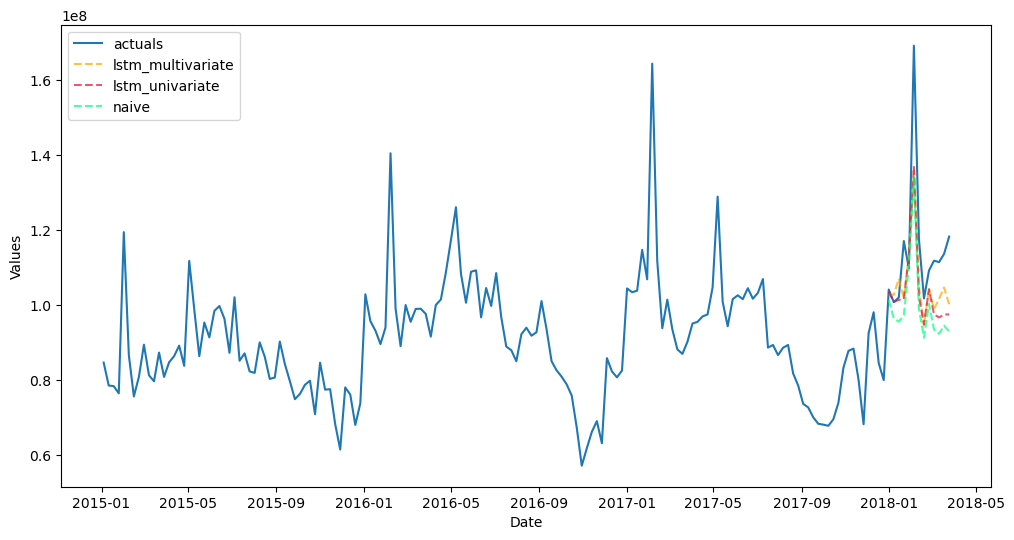

In [14]:
fvol.plot_test_set(order_by='TestSetRMSE')
plt.savefig('LSTM MV test results.png')
plt.show()

In [15]:
pd.options.display.float_format = '{:,.4f}'.format
summ = fvol.export('model_summaries',determine_best_by='TestSetRMSE')
summ[['ModelNickname','TestSetRMSE','TestSetR2']]

,ModelNickname,TestSetRMSE,TestSetR2
0,lstm_multivariate,"13,241,317.9599",0.3837
1,lstm_univariate,"14,475,008.6416",0.2635
2,naive,"17,403,456.6059",-0.0646


In [16]:
summ[['ModelNickname','HyperParams']].style.set_properties(height = 5)

,ModelNickname,HyperParams
0,lstm_multivariate,"{'verbose': 0, 'epochs': 100, 'validation_split': 0.2, 'callbacks': , 'layers_struct': [('LSTM', {'units': 100, 'activation': 'tanh', 'dropout': 0.05, 'return_sequences': False}, 'LSTM', {'units': 100, 'activation': 'tanh', 'dropout': 0.05}, 'LSTM', {'units': 100, 'activation': 'tanh', 'dropout': 0.05})]}"
1,lstm_univariate,"{'verbose': 0, 'epochs': 100, 'validation_split': 0.2, 'callbacks': , 'layers_struct': [('LSTM', {'units': 100, 'activation': 'relu', 'dropout': 0.0, 'return_sequences': False}, 'LSTM', {'units': 100, 'activation': 'relu', 'dropout': 0.0}, 'LSTM', {'units': 100, 'activation': 'relu', 'dropout': 0.0})]}"
2,naive,{}


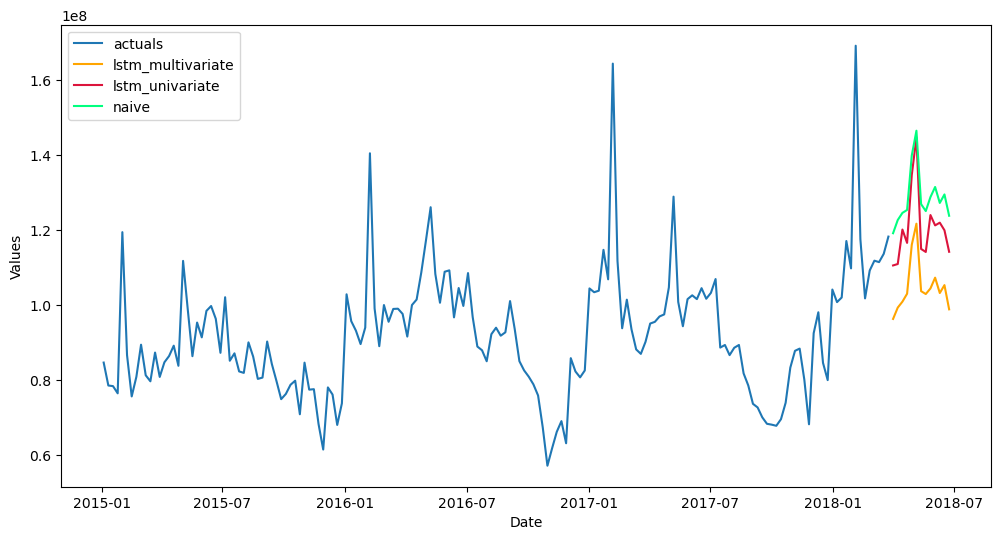

In [17]:
fvol.plot(order_by='TestSetRMSE')
plt.show()

## Problem 3 - Probabilistic Forecasting

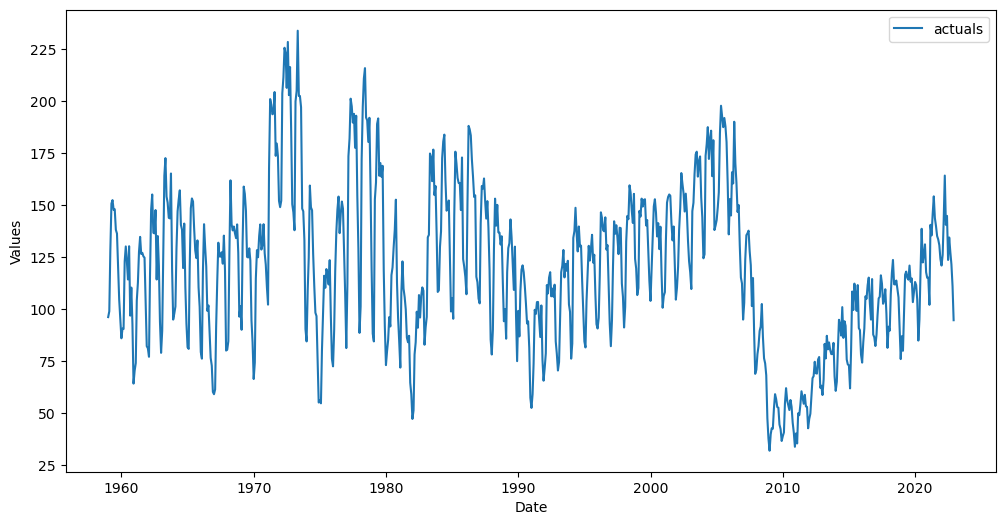

In [2]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2022-12-31',
)

f = Forecaster(
    y = df['HOUSTNSA'],
    current_dates = df.index,
    future_dates = 24, # 2-year forecast horizon
    test_length = .1, # 10% test length
    cis = True,
    cilevel = .9, # 90% intervals
)

f.plot()
plt.show()

In [3]:
transformer, reverter = find_optimal_transformation(
    f,
    estimator = 'lstm',
    epochs = 10,
    set_aside_test_set=True, # prevents leakage so we can benchmark the resulting models fairly
    return_train_only = True, # prevents leakage so we can benchmark the resulting models fairly
    verbose=True,
    m = 52, # what makes one seasonal cycle?
    test_length = 24,
    num_test_sets = 3,
    space_between_sets = 12,
    detrend_kwargs=[
        {'loess':True},
        {'poly_order':1},
        {'ln_trend':True},
    ],
)

Using lstm model to find the best transformation set on 3 test sets, each 24 in length.
Epoch 1/10
17/17 [==============================] - 2s 3ms/step - loss: 0.4265
Epoch 2/10
17/17 [==============================] - 0s 3ms/step - loss: 0.4051
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 0.3817
Epoch 4/10
17/17 [==============================] - 0s 3ms/step - loss: 0.3553
Epoch 5/10
17/17 [==============================] - 0s 3ms/step - loss: 0.3252
Epoch 6/10
17/17 [==============================] - 0s 4ms/step - loss: 0.2918
Epoch 7/10
17/17 [==============================] - 0s 4ms/step - loss: 0.2571
Epoch 8/10
17/17 [==============================] - 0s 4ms/step - loss: 0.2244
Epoch 9/10
17/17 [==============================] - 0s 4ms/step - loss: 0.1972
Epoch 10/10
1/1 [==============================] - 0s 485ms/step
Epoch 1/10
21/21 [==============================] - 3s 3ms/step - loss: 0.4330
Epoch 2/10
21/21 [==============================] - 0s 3m

In [4]:
rnn_grid = gen_rnn_grid(
    layer_tries = 100,
    min_layer_size = 1,
    max_layer_size = 5,
    units_pool = [100],
    epochs = [100],
    dropout_pool = [0,0.05],
    validation_split=.2,
    callbacks=EarlyStopping(
      monitor='val_loss',
      patience=3,
    ),
    random_seed = 20,
) # make a really big grid and limit it manually

In [5]:
def forecaster(f,grid):
    f.auto_Xvar_select(
        try_trend=False,
        try_seasonalities=False,
        max_ar=100
    )
    f.set_estimator('rnn')
    f.ingest_grid(grid)
    f.limit_grid_size(10) # randomly reduce the big grid to 10
    f.cross_validate(k=3,test_length=24) # three-fold cross-validation
    f.auto_forecast()

In [6]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f = pipeline.fit_predict(f,grid=rnn_grid)

1/1 [==============================] - 0s 167ms/step
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-09-20 11:49:23         2235
metadata.json                                  2023-09-20 11:49:23           64
variables.h5                                   2023-09-20 11:49:23       537280
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-09-20 11:49:22         2235
me

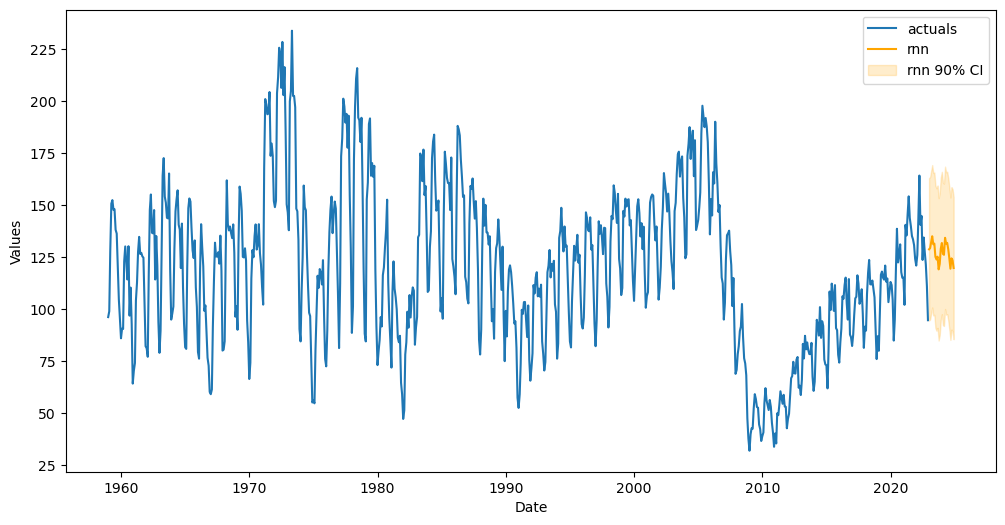

In [7]:
f.plot(ci=True)
plt.savefig('Probabilistic LSTM.png')
plt.show()

## Problem 4 - Dynamic Probabilistic Forecasting

In [8]:
params = f.best_params
num_chosen_lags = len(f.get_regressor_names())

In [9]:
def forecaster(f,params):
    f.set_estimator('rnn')
    f.manual_forecast(**params,test_again=False,lags=num_chosen_lags)

In [10]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

In [11]:
f = pipeline.fit_predict(f,params = params)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-09-20 11:49:34         2235
metadata.json                                  2023-09-20 11:49:34           64
variables.h5                                   2023-09-20 11:49:34       537280
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-09-20 11:49:34         2235
metadata.json                                  2023-09-

In [12]:
backtest_results = backtest_for_resid_matrix(
    f,
    pipeline=pipeline,
    alpha = .1,
    jump_back = 12,
    params = f.best_params,
)

19/19 [==============================] - 0s 4ms/step


In [13]:
backtest_resid_matrix = get_backtest_resid_matrix(backtest_results)

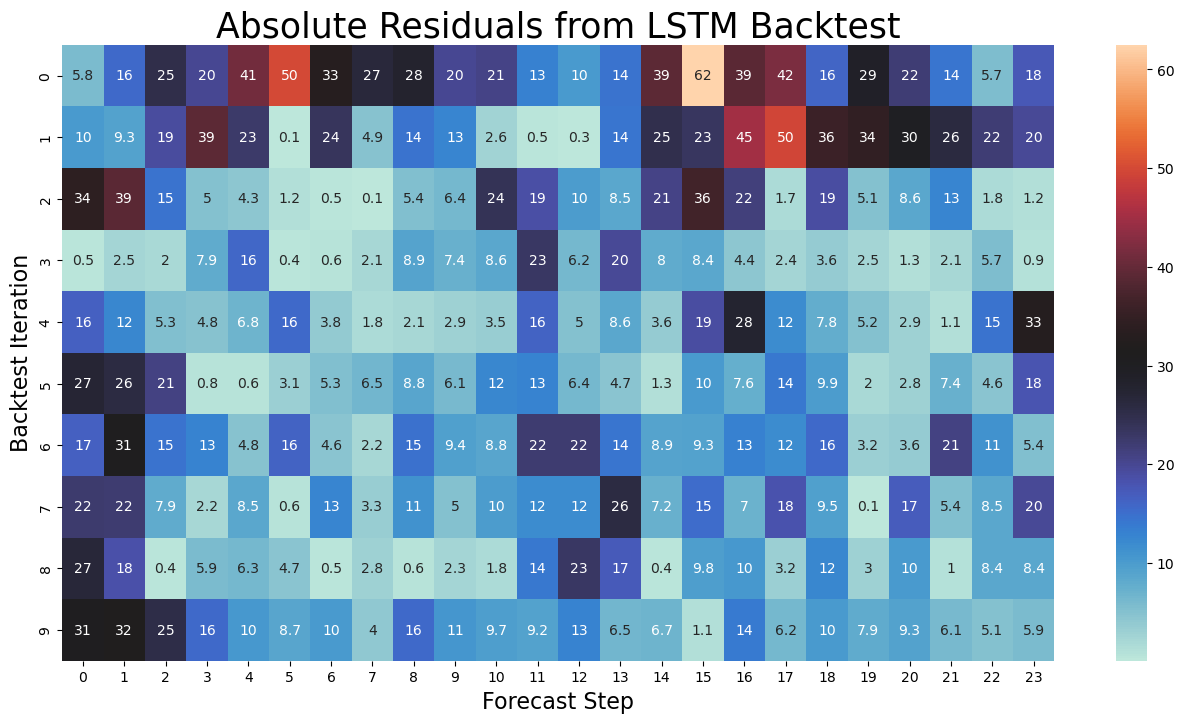

In [14]:
pd.options.display.max_columns = None
fig, ax = plt.subplots(figsize=(16,8))
mat = pd.DataFrame(np.abs(backtest_resid_matrix[0]['rnn']))
sns.heatmap(
    mat.round(1),
    annot = True,
    ax = ax,
    cmap = sns.color_palette("icefire", as_cmap=True),
)
plt.ylabel('Backtest Iteration',size=16)
plt.xlabel('Forecast Step',size = 16)
plt.title('Absolute Residuals from LSTM Backtest',size=25)
plt.savefig('LSTM Resid Matrix.png')
plt.show()

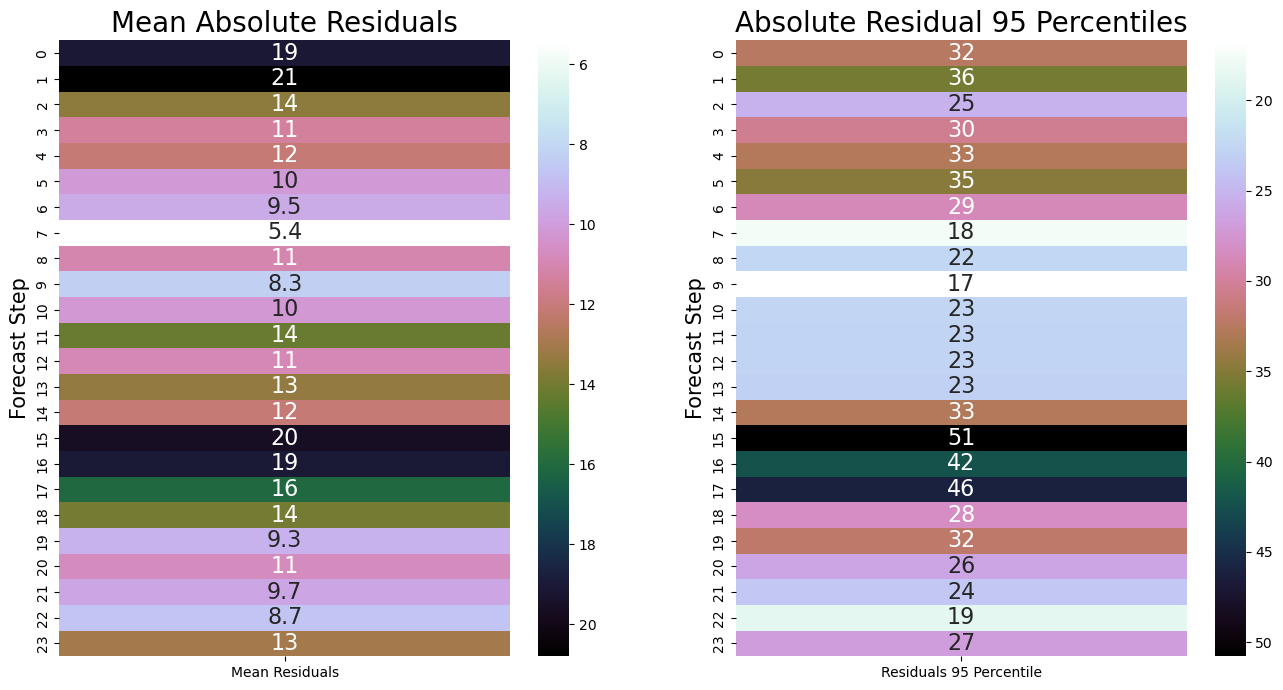

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.heatmap(
    pd.DataFrame({'Mean Residuals':mat.mean().round(1)}),
    annot = True,
    cmap = 'cubehelix_r',
    ax = ax[0],
    annot_kws={"fontsize": 16},
)
cbar = ax[0].collections[0].colorbar
cbar.ax.invert_yaxis()
ax[0].set_title('Mean Absolute Residuals',size=20)
ax[0].set_ylabel('Forecast Step',size=15)
ax[0].set_xlabel('')
sns.heatmap(
    pd.DataFrame({'Residuals 95 Percentile':np.percentile(mat, q=95, axis = 0)}),
    annot = True,
    cmap = 'cubehelix_r',
    ax = ax[1],
    annot_kws={"fontsize": 16},
)
cbar = ax[1].collections[0].colorbar
cbar.ax.invert_yaxis()
ax[1].set_title('Absolute Residual 95 Percentiles',size=20)
ax[1].set_ylabel('Forecast Step',size=15)
ax[1].set_xlabel('')
plt.show()

In [16]:
overwrite_forecast_intervals(f,backtest_resid_matrix=backtest_resid_matrix,alpha=.1)

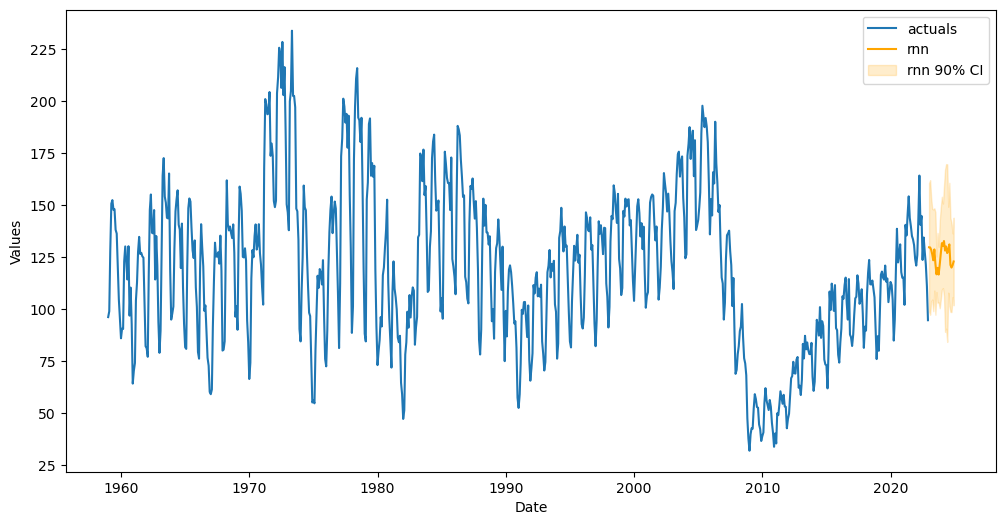

In [17]:
f.plot(ci=True)
plt.savefig('LSTM dynamic intervals.png')
plt.show()

## Problem 5 - Transfer Learning

### Scenario 1: New data from the same series

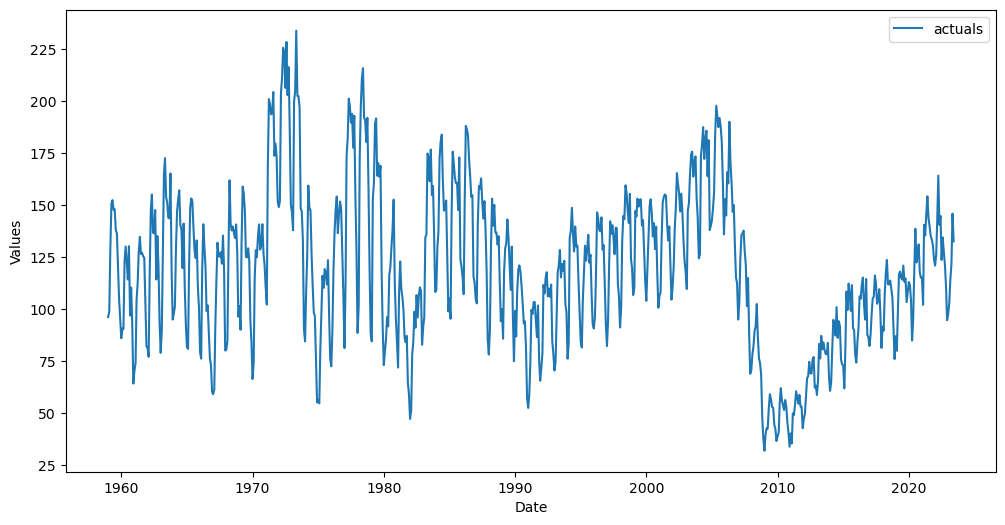

In [49]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2023-06-30',
)

f_new = Forecaster(
    y = df.iloc[:,0],
    current_dates = df.index,
    future_dates = 24, # 2-year forecast horizon
)

f_new.plot()
plt.show()

In [50]:
def transfer_forecast(f_new,transfer_from):
    f_new = infer_apply_Xvar_selection(
        infer_from=transfer_from,
        apply_to=f_new
    )
    f_new.transfer_predict(
        transfer_from=transfer_from,
        model='rnn',
        model_type='tf'
    )

In [51]:
pipeline_can = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Transfer Forecast',transfer_forecast),
        ('Revert',reverter),
    ]
)

f_new = pipeline_can.fit_predict(f_new,transfer_from=f)

24/24 [==============================] - 0s 3ms/step


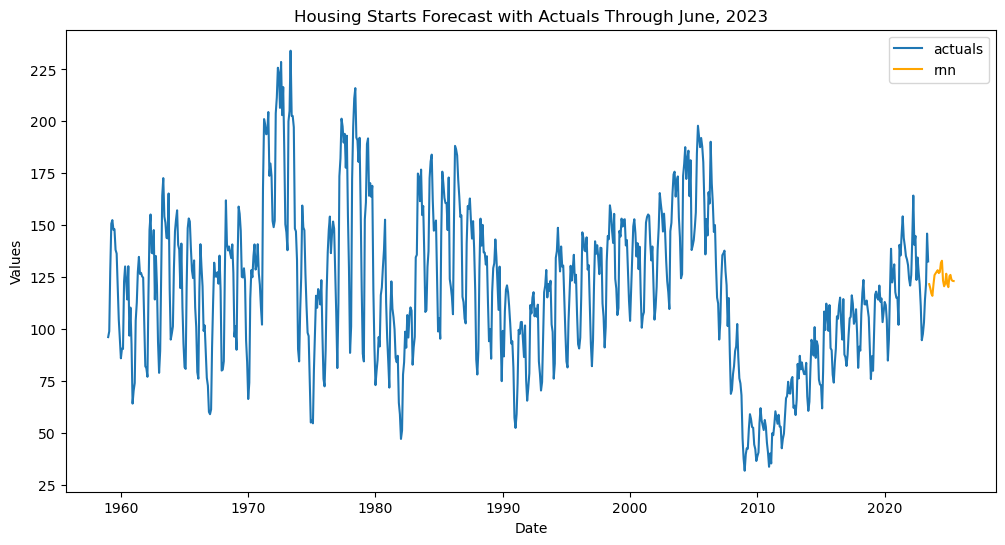

In [53]:
f_new.plot()
plt.title('Housing Starts Forecast with Actuals Through June, 2023')
plt.savefig('RNN transferred same series.png')
plt.show()

### Scenario 2: A new time series with similar characteristics

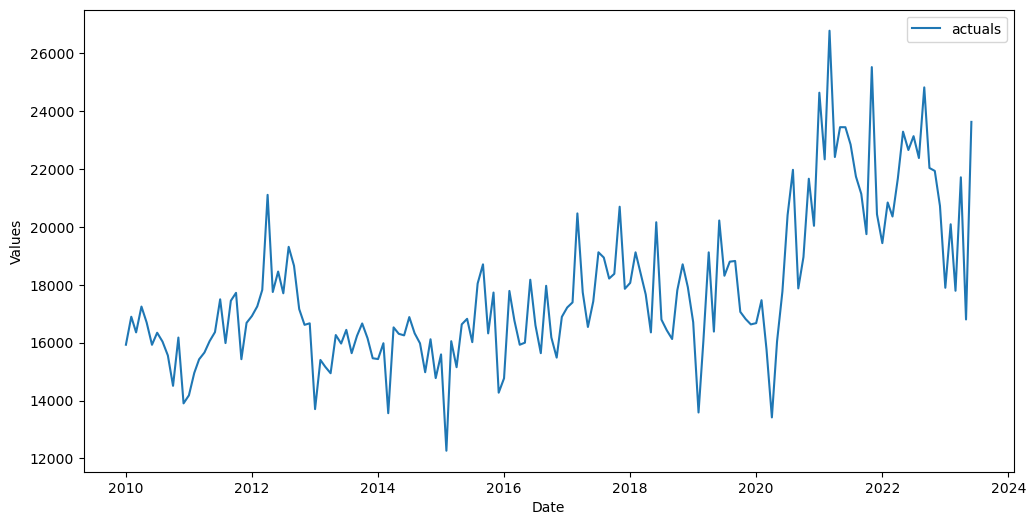

In [54]:
df = pdr.get_data_fred(
    'CANWSCNDW01STSAM',
    start = '2010-01-01',
    end = '2023-06-30',
)

f_new = Forecaster(
    y = df.iloc[:,0],
    current_dates = df.index,
    future_dates = 24, # 2-year forecast horizon
)

f_new.plot()
plt.show()

In [55]:
def transfer_forecast(f_new,transfer_from):
    f_new = infer_apply_Xvar_selection(
        infer_from=transfer_from,
        apply_to=f_new
    )
    f_new.transfer_predict(
        transfer_from=transfer_from,
        model='rnn',
        model_type='tf'
    )

In [56]:
pipeline_can = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Transfer Forecast',transfer_forecast),
        ('Revert',reverter),
    ]
)

f_new = pipeline_can.fit_predict(f_new,transfer_from=f)

4/4 [==============================] - 0s 4ms/step


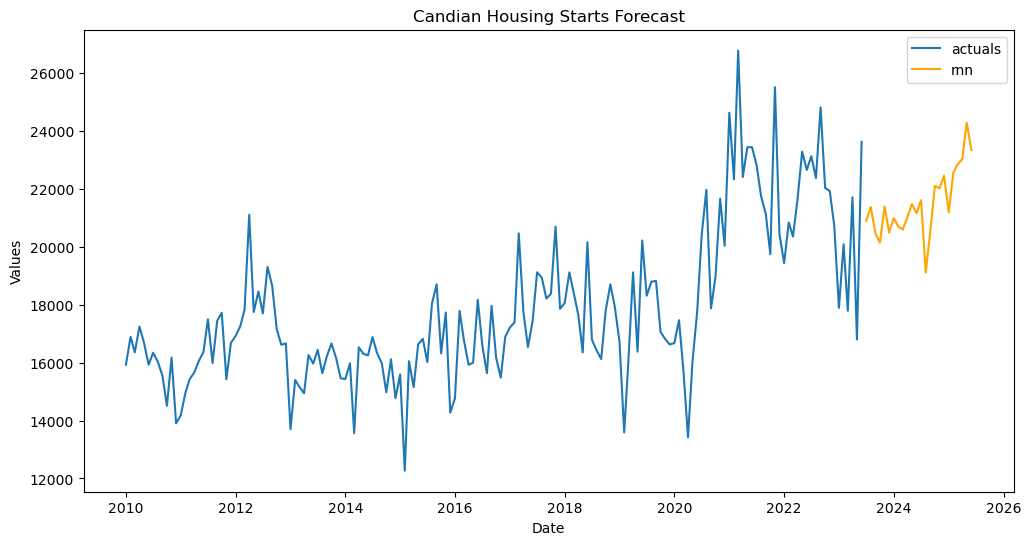

In [57]:
f_new.plot()
plt.title('Candian Housing Starts Forecast')
plt.savefig('Transferred RNN Canada')
plt.show()